In [4]:
import metpy.calc as mpcalc
import matplotlib as mpl
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
import scipy.ndimage as ndimage
import metpy 
from metpy.plots import USCOUNTIES # Make sure metpy is updated to latest version.
import glob
import datetime
import pandas as pd
from pathlib import Path
%matplotlib inline
plt.rcParams.update({"font.size":30})
mpl.rcParams['legend.fontsize'] = 'large'


In [5]:
date_rng = pd.date_range(start='11/07/2018 12:00:00', end='11/09/2018 18:00:00', freq='6H') ## I'm creating this date range which corresponds to all of my analysis files 
dt_rng = xr.DataArray.from_series(date_rng) # I then turn the series into a xarray data array to be used later for the concatination dimension
data= glob.glob("/export/home/mbrewer/GFS/*.grb2")
ds = xr.open_mfdataset(data, engine = 'pynio',concat_dim = dt_rng.data) # reading in an concatinating all GFS anl files using the above date range as the concat dim to make indexing somewhat easier later on

el = Path("/export/home/mbrewer/Documents/GMTED2010_15n030_0125deg.nc") # Reading in my 0.125 degree elevation dataset
elev = xr.open_dataset(el)

In [6]:
def findlev_ind(lev): ##
    
    """ input level in hPa
    This function is used to find the closest isobaric level
    what the user has requested"""
    
    ds_levs = ds.lv_ISBL0
    lev = lev*100 #Correct level to Pa
    z = np.abs(ds_levs - lev).argmin()
    return int(z)

def latlon_grid(gr_lat, gr_lon):
    
    """ This function is used to find the closest grid box to a given
    lat and lon that the user has requested what the user has requested
    The function return the grid coordinates in X then Y grid values"""
    
    lat = ds.lat_0
    lon = ds.lon_0

    abs_lat = np.abs(lat - gr_lat)
    abs_lon = np.abs(lon - gr_lon)

    c = np.maximum(abs_lon, abs_lat)
    xx, yy = np.where(c == np.min(c))
    return xx,yy

def t_ind(time):
    
    """input time sting in Y-m-d H:M:S format """

    ds_time = ds.coords['concat_dim']
    time = np.datetime64(time)
    T_ind = np.where(ds_time == time)
    return int(T_ind[0])

def smooth(var,z,t):
    
    """ input lev in hPa
    input time in Y-m-d H:M:S format string """
    
    level = findlev_ind(z)
    #time = t_ind(t)
    return ndimage.gaussian_filter(var[t, level], sigma = 1.5, order = 0)
crs = ccrs.PlateCarree() ## this GFS output is on a normal lat lon grid

In [7]:
# Function used to create the map subplots
def plot_background(ax):
    ax.set_extent([-105+360.,-138+360., 32., 52.])
    ax.coastlines(resolution='10m', linewidth=2, color = 'black', zorder = 4)
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

    ax.add_feature(political_boundaries, linestyle='-', edgecolor='black', zorder =4)
    ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2, zorder =4)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

In [8]:
p_lat = 39.69
p_lon = -121.57 + 360 ### Adding  360 since the GFS output on is 0-360
xx,yy = latlon_grid(p_lat, p_lon)

ymin = int(yy - 30)
ymax = int(yy + 30)
                    ####### Making these mins and maxs to index the data so plotting works better and faster.... Also the fucking contour labels will show up
xmin = int(xx - 35)
xmax = int(xx + 35)


In [9]:
### parsing the dataset to due to the variables being not very human readable

                            ## all times, all levels
heights = ds.HGT_P0_L100_GLL0[:, :, ymin:ymax, xmin:xmax]
uwind = ds.UGRD_P0_L100_GLL0[:, :, ymin:ymax, xmin:xmax]
vwind = ds.VGRD_P0_L100_GLL0[:, :, ymin:ymax, xmin:xmax]
RH = ds.RH_P0_L100_GLL0[:, :, ymin:ymax, xmin:xmax]
T = ds.TMP_P0_L100_GLL0[:, :, ymin:ymax, xmin:xmax]
abv = ds.ABSV_P0_L100_GLL0[:, :, ymin:ymax, xmin:xmax]

                            ## all times, 10m & 80m 
vwind_agl = ds.VGRD_P0_L103_GLL0[:, :, ymin:ymax, xmin:xmax]
uwind_agl = ds.UGRD_P0_L103_GLL0[:, :, ymin:ymax, xmin:xmax]

                            ## all times
dpt_2m = ds.DPT_P0_L103_GLL0[:, ymin:ymax, xmin:xmax]
RH_2m = ds.RH_P0_L103_GLL0[:, ymin:ymax, xmin:xmax]
pres = ds.MSLET_P0_L101_GLL0[:, ymin:ymax, xmin:xmax]

lon_2d, lat_2d = np.meshgrid(ds.lon_0[xmin:xmax], ds.lat_0[ymin:ymax])


In [21]:
# between lat/lon grid points
dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d, lat_2d)

# Because of the way the data are returned we need a negative spacing. This
# will be easier in the next version of MetPy.




In [22]:

for t in range(len(date_rng)):
    ### Variable that you want to plot
    plot_heights = True
    plot_winds = True
    if plot_heights == True:
        h = 300
        z_i = findlev_ind(h)
        H_var = smooth(heights, h, t)
    var = T[t,z_i]-273.15 #contours
    var2 = abv[t,z_i] *1e5#mpcalc.wind_speed(uwind[t,z_i].values, vwind[t,z_i].values) #colorfill
    sknum = 3  ## value used to skip grids for plotting wind barbs  
    ### Use this for magnitude of wind: np.array(mpcalc.wind_speed(uwind[t_i,z_i]*units('meter/second'), vwind[t_i,z_i]*units('meter/second')))
    adv = mpcalc.advection(T[t,z_i] * units.kelvin, [uwind[t,z_i]*units('m/s'), vwind[t,z_i]*units('m/s')],(dx,dy))

    # Smooth heights and advection a little
    adv = ndimage.gaussian_filter(adv, sigma=3, order=0) * units('K/sec')

    fig, ax = plt.subplots(figsize = (20,20),subplot_kw={'projection': crs})
    plot_background(ax)
    
    clevs = np.arange(5,45,1)
    Hlevs = np.arange(int(H_var.min()),int(H_var.max()), 3)
    levs = np.arange(int(var.min()),int(var.max()),2)
    
    cf = ax.contourf(lon_2d,lat_2d,adv,clevs, transform = ccrs.PlateCarree(), cmap = 'cool', alpha = .7, zorder = 2,)
    cs1 =ax.contour(elev.longitude,elev.latitude, elev.elevation, levs, transform = ccrs.PlateCarree(), colors = '#333333', zorder = 1)
    
    cs1 =ax.contour(lon_2d,lat_2d, var,levs,transform = ccrs.PlateCarree(), linewidths = 3, colors = 'red', linestyle = '--')
    ax.clabel(cs1, colors='black',fontsize = 15, fmt = '%.1f')

    if plot_heights == True:
        levs2 = np.arange(H_var.min()/10,H_var.max()/10.,3)
        cs =ax.contour(lon_2d,lat_2d, H_var/10,Hlevs, transform = ccrs.PlateCarree(), linewidths = 3, colors = 'black')
        ax.clabel(cs, colors='black',fontsize = 15, fmt = '%.1f')

    ax.scatter(-121.6219, 39.7596, s =300,  marker = '*', label = 'Paradise, California', transform = ccrs.PlateCarree(), color = 'tab:red', zorder =6)
    if plot_winds ==True:
        skip=(slice(None,None,sknum),slice(None,None,sknum))
        ax.barbs(lon_2d[skip],lat_2d[skip], uwind[t, z_i][skip],vwind[t, z_i][skip], length=6,
                     sizes=dict(emptybarb=0.25, spacing=.2, height=0.5),
                     zorder = 5,
                     linewidth=0.95, transform= ccrs.PlateCarree())

    ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=.2, zorder = 4)
    ax.legend(loc = 1,fontsize = '18')
    cb = fig.colorbar(cf, shrink=0.5, pad=0.01 )
    font_size = 20 # Adjust as appropriate.
    cb.ax.tick_params(labelsize=font_size)
    cb.set_label('Dew Point Temperature ($\degree$C)', size = 'x-large', fontsize = 22 )
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(30)
        label.set_fontweight('bold');
    #plt.title('GFS 0.5$\degree$', loc='left', fontweight='bold', fontsize = 22)
    #plt.title('Color Fill: Dew Point Temperature $\degree$C\n Contours: MLSP (hPa)' , loc='center', fontsize = 18)
    plt.title('Valid Time: %s PST' % (date_rng[t].tz_localize('UTC').tz_convert('US/Pacific').strftime("%Y-%m-%d %H:%M:%S")), loc='left', fontsize = 18)

    #plt.savefig('GFS_%s_%sPST.png'% (var2.attrs['long_name'],date_rng[t].tz_localize('UTC').tz_convert('US/Pacific').strftime("%Y-%m-%d %H:%M:%S")),dpi = 300, bbox_inches = 'tight')

/export/home/mbrewer/anaconda3/envs/grib/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


TypeError: invalid indexer array, does not have integer dtype: array(None, dtype=object)

/export/home/mbrewer/anaconda3/envs/grib/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/export/home/mbrewer/anaconda3/envs/grib/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


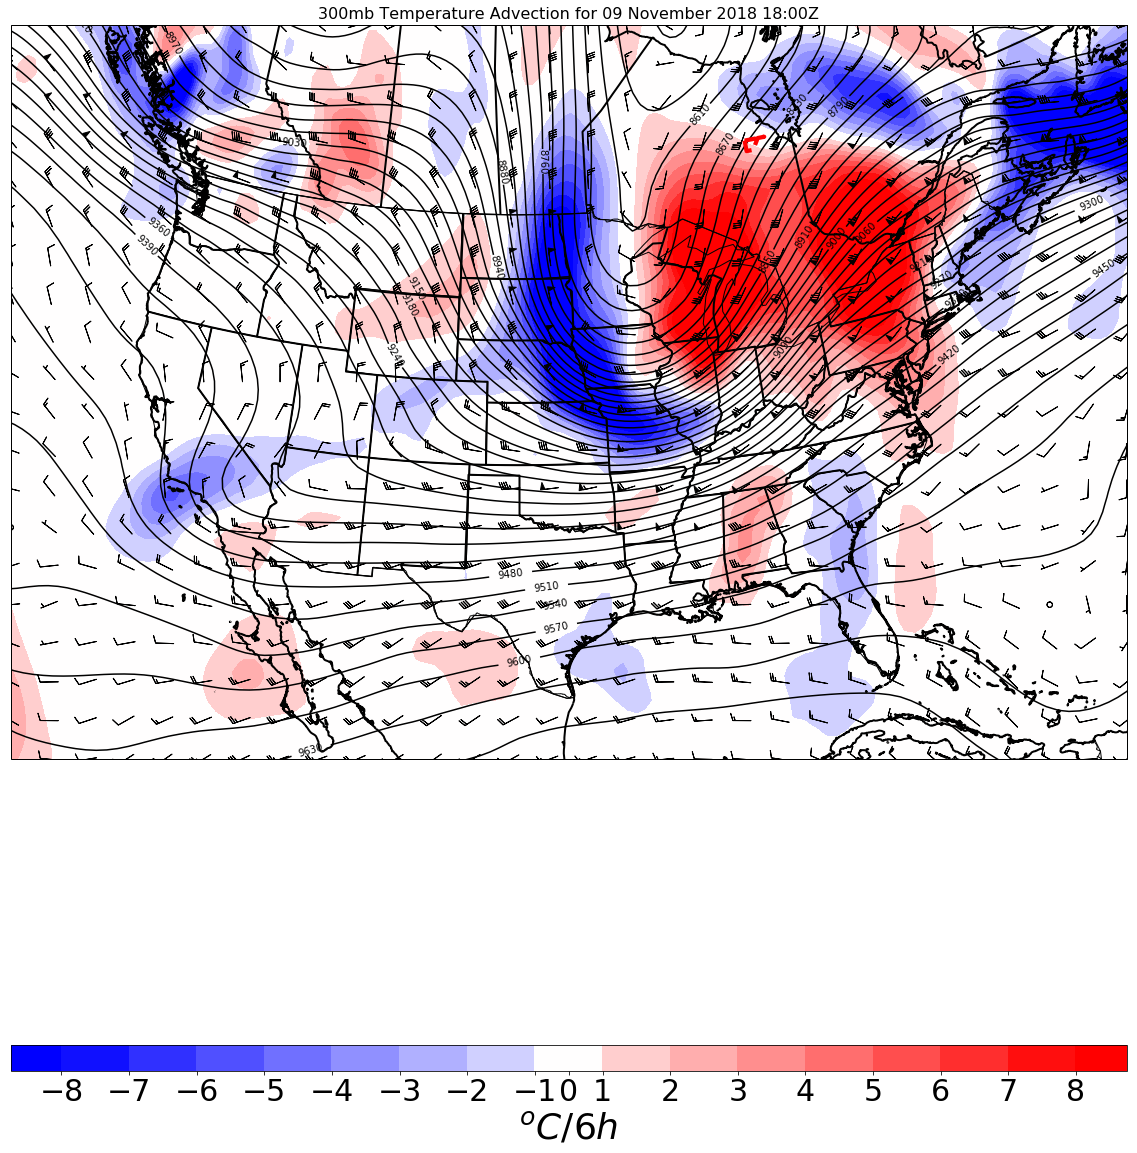

In [95]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.ncss import NCSS
#######################################
# Data Aquisition
# ---------------
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)
# Open the example netCDF data
base_url = 'https://www.ncei.noaa.gov/thredds/ncss/grid/gfs-g4-anl-files/'
dt = datetime(2018, 11, 9,18)
ncss = NCSS('{}{dt:%Y%m}/{dt:%Y%m%d}/gfsanl_4_{dt:%Y%m%d}_'
            '{dt:%H}00_000.grb2'.format(base_url, dt=dt))
# Create lat/lon box for location you want to get data for
query = ncss.query().time(dt)
query.lonlat_box(north=65, south=15, east=310, west=220)
query.accept('netcdf')

# Request data for vorticity
query.variables('Geopotential_height_isobaric', 'Temperature_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
data = ncss.get_data(query)

# Pull out variables you want to use
hght_var = data.variables['Geopotential_height_isobaric']
temp_var = data.variables['Temperature_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']
time_var = data.variables[find_time_var(temp_var)]
lat_var = data.variables['lat']
lon_var = data.variables['lon']

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
hght = hght_var[:].squeeze()
temp = temp_var[:].squeeze() * units.K
u_wind = units('m/s') * u_wind_var[:].squeeze()
v_wind = units('m/s') * v_wind_var[:].squeeze()

# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)

lev_300 = np.where(data.variables['isobaric'][:] == 300*100)[0][0]
hght_300 = hght[lev_300]
temp_300 = temp[lev_300]
u_wind_300 = u_wind[lev_300]
v_wind_300 = v_wind[lev_300]

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)
# Gridshift for barbs
lon_2d[lon_2d > 180] = lon_2d[lon_2d > 180] - 360

# Use helper function defined above to calculate distance
# between lat/lon grid points
dx, dy = mpcalc.lat_lon_grid_deltas(lon_var, lat_var)

# Because of the way the data are returned we need a negative spacing. This
# will be easier in the next version of MetPy.

# Calculate temperature advection using metpy function
adv = mpcalc.advection(temp_300 * units.kelvin, [u_wind_300, v_wind_300],
                       (dx, dy)) * units('K/sec')

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
Z_300 = ndimage.gaussian_filter(hght_300, sigma=1.5, order=0) * units.meter
adv_300 = ndimage.gaussian_filter(adv, sigma=1.5, order=0) * units('K/sec')

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=plotcrs)
plt.title('300mb Temperature Advection for {0:%d %B %Y %H:%MZ}'.format(time), fontsize=16)
ax.set_extent([235., 290., 20., 55.])

# Add state/country boundaries to plot
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.coastlines(resolution='10m', linewidth=2, color = 'black', zorder = 4)
political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

ax.add_feature(political_boundaries, linestyle='-', edgecolor='black', zorder =4)
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2, zorder =4)

# Plot Height Contours
clev300 = np.arange(900, 12000, 30)
cs = ax.contour(lon_2d, lat_2d, Z_300, clev300, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp300 = np.arange(-20, 20, 2)
cs2 = ax.contour(lon_2d, lat_2d, temp_300.to(units('degC')), clevtemp300,
                 colors='red', linewidths=4.25, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=20, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
cint = np.arange(-8, 9)
cf = ax.contourf(lon_2d, lat_2d, 6*adv_300.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
cax = plt.subplot(gs[1])
cb = plt.colorbar(cf, cax=cax, orientation='horizontal', extendrect=True, ticks=cint)
cb.set_label(r'$^{o}C/6h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_300.magnitude, v_wind_300.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)

plt.show()

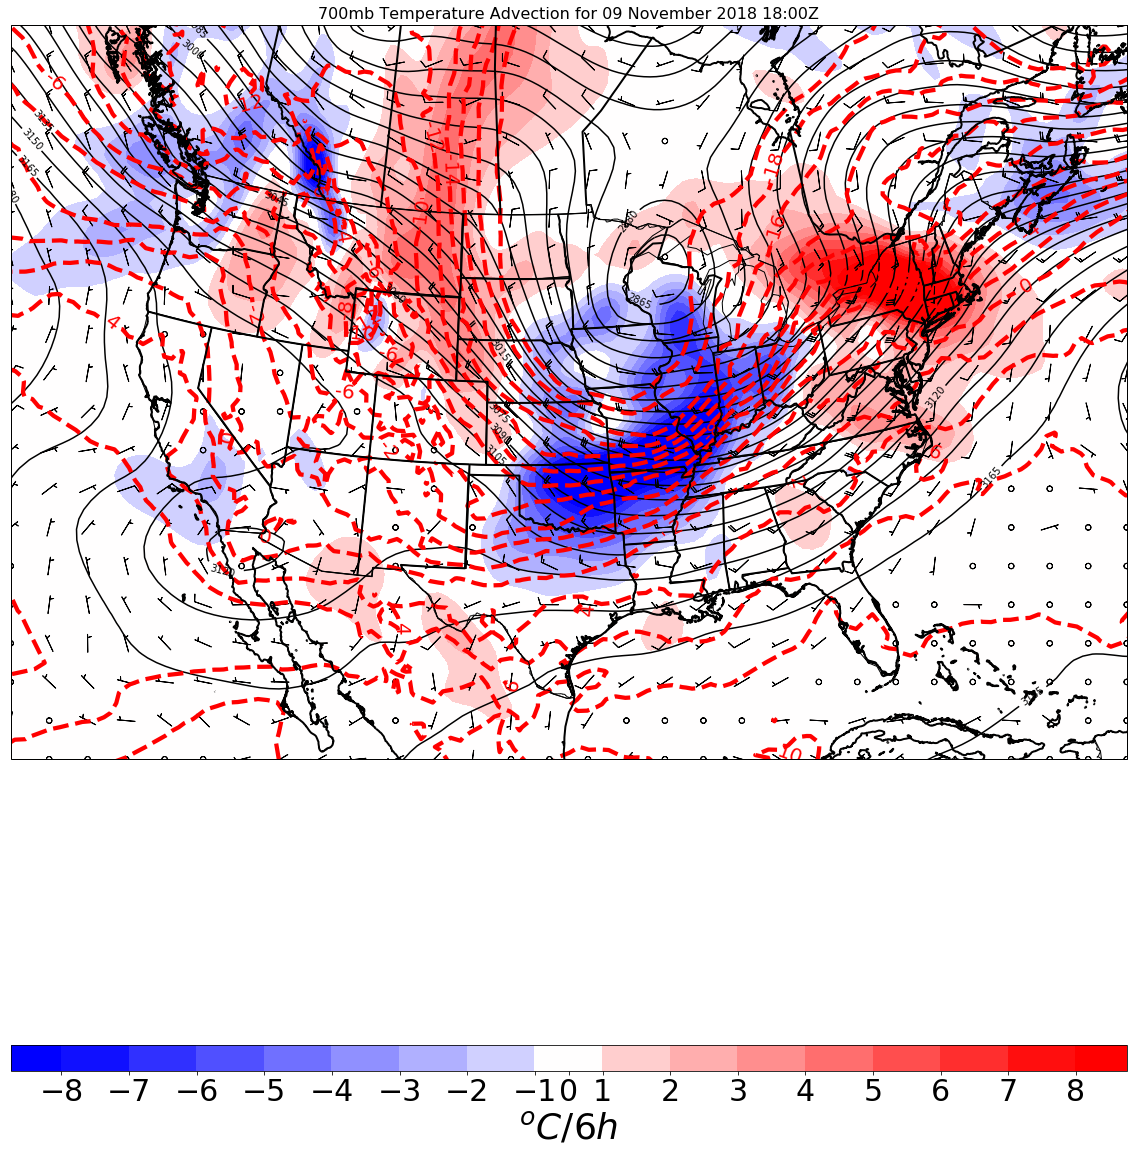

In [96]:
lev_700 = np.where(data.variables['isobaric'][:] == 700*100)[0][0]
hght_700 = hght[lev_700]
temp_700 = temp[lev_700]
u_wind_700 = u_wind[lev_700]
v_wind_700 = v_wind[lev_700]

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)
# Gridshift for barbs
lon_2d[lon_2d > 180] = lon_2d[lon_2d > 180] - 360

# Use helper function defined above to calculate distance
# between lat/lon grid points
dx, dy = mpcalc.lat_lon_grid_deltas(lon_var, lat_var)

# Because of the way the data are returned we need a negative spacing. This
# will be easier in the next version of MetPy.

# Calculate temperature advection using metpy function
adv = mpcalc.advection(temp_700 * units.kelvin, [u_wind_700, v_wind_700],
                       (dx, dy)) * units('K/sec')

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
Z_700 = ndimage.gaussian_filter(hght_700, sigma=1.5, order=0) * units.meter
adv_700 = ndimage.gaussian_filter(adv, sigma=1.5, order=0) * units('K/sec')

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=plotcrs)
plt.title('700mb Temperature Advection for {0:%d %B %Y %H:%MZ}'.format(time), fontsize=16)
ax.set_extent([235., 290., 20., 55.])

# Add state/country boundaries to plot
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.coastlines(resolution='10m', linewidth=2, color = 'black', zorder = 4)
political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

ax.add_feature(political_boundaries, linestyle='-', edgecolor='black', zorder =4)
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2, zorder =4)
# Plot Height Contours
clev700 = np.arange(900, 7000, 15)
cs = ax.contour(lon_2d, lat_2d, Z_700,clev700,  colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp700 = np.arange(-20, 20, 2)
cs2 = ax.contour(lon_2d, lat_2d, temp_700.to(units('degC')), clevtemp700,
                 colors='red', linewidths=4.25, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=20, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
cint = np.arange(-8, 9)
cf = ax.contourf(lon_2d, lat_2d, 6*adv_700.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
cax = plt.subplot(gs[1])
cb = plt.colorbar(cf, cax=cax, orientation='horizontal', extendrect=True, ticks=cint)
cb.set_label(r'$^{o}C/6h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_700.magnitude, v_wind_700.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)

plt.show()

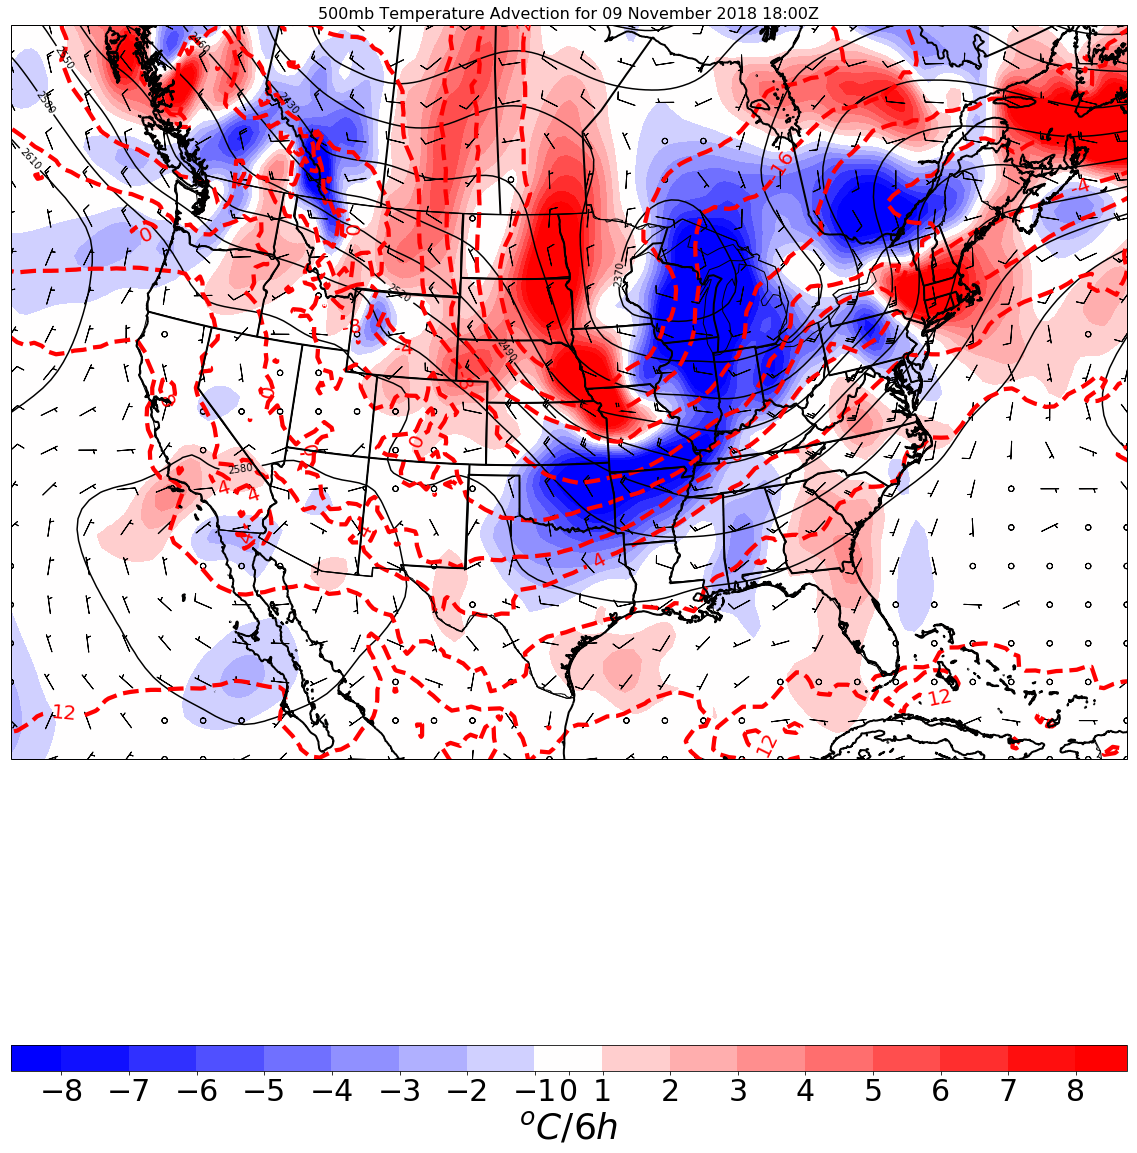

In [98]:
lev_500 = np.where(data.variables['isobaric'][:] == 750*100)[0][0]
hght_500 = hght[lev_500]
temp_500 = temp[lev_500]
u_wind_500 = u_wind[lev_500]
v_wind_500 = v_wind[lev_500]

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)
# Gridshift for barbs
lon_2d[lon_2d > 180] = lon_2d[lon_2d > 180] - 360

# Use helper function defined above to calculate distance
# between lat/lon grid points
dx, dy = mpcalc.lat_lon_grid_deltas(lon_var, lat_var)

# Because of the way the data are returned we need a negative spacing. This
# will be easier in the next version of MetPy.

# Calculate temperature advection using metpy function
adv = mpcalc.advection(temp_500 * units.kelvin, [u_wind_500, v_wind_500],
                       (dx, dy)) * units('K/sec')

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
Z_500 = ndimage.gaussian_filter(hght_500, sigma=1.5, order=0) * units.meter
adv_500 = ndimage.gaussian_filter(adv, sigma=1.5, order=0) * units('K/sec')

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=plotcrs)
plt.title('500mb Temperature Advection for {0:%d %B %Y %H:%MZ}'.format(time), fontsize=16)
ax.set_extent([235., 290., 20., 55.])

# Add state/country boundaries to plot
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.coastlines(resolution='10m', linewidth=2, color = 'black', zorder = 4)
political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

ax.add_feature(political_boundaries, linestyle='-', edgecolor='black', zorder =4)
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2, zorder =4)
# Plot Height Contours
clev500 = np.arange(900, 9000, 30)
cs = ax.contour(lon_2d, lat_2d, Z_500, clev500, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp500 = np.arange(-20, 20, 4)
cs2 = ax.contour(lon_2d, lat_2d, temp_500.to(units('degC')), clevtemp500,
                 colors='red', linewidths=4.25, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=20, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)


# Plot Colorfill of Temperature Advection
cint = np.arange(-8, 9)
cf = ax.contourf(lon_2d, lat_2d, 6*adv_700.to(units('delta_degC/hour'))-6*adv_300.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
cax = plt.subplot(gs[1])
cb = plt.colorbar(cf, cax=cax, orientation='horizontal', extendrect=True, ticks=cint)
cb.set_label(r'$^{o}C/6h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_500.magnitude, v_wind_500.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)
plt.show()